#### 1. Install dependencies and setup

In [245]:
%pip install tensorflow opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt

2023-08-29 11:25:41.532975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')

# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)

tf.config.experimental.list_physical_devices('GPU')

2023-08-29 11:25:43.799052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-29 11:25:43.799230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-29 11:25:43.803984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
##### 1.2 Load data

In [213]:
from get_dataset import DataSetLoader

dataset_loader = DataSetLoader()

# Set the path to the root directory containing the images
directory = '/data/train'

# Set the label map that maps directory names to class labels
label_map = {'ad': 0, 'nonad': 1}

# Collect the file paths and labels for all images
file_paths, labels = dataset_loader.collect_images(directory, label_map)

# Create a dataset from the file paths and labels
dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

def load_image(file_path, label):
    # Read the binary content of the image file
    binary_image = tf.io.read_file(file_path)
    # Decode the binary image data
    image = tf.io.decode_image(binary_image)
    # Set the shape of the image tensor explicitly
    image.set_shape([None, None, None])
    # Convert the image from RGBA to RGB format by discarding the alpha channel
    image = image[..., :3]
    # Resize the image to a fixed size
    image = tf.image.resize(image, [256, 256])
    return image, label

# Map the load_image function over the dataset
dataset = dataset.map(load_image)

# Shuffle and batch the dataset
shuffled_dataset = dataset.shuffle(buffer_size=1024)
batched_dataset = shuffled_dataset.batch(batch_size=32)

# Create an iterator over the dataset
iterator = batched_dataset.as_numpy_iterator()

In [214]:
try:
    batch = next(iterator)
    print(batch[0].shape)
except OutOfRangeError as e:
    print(e)

(32, 256, 256, 3)


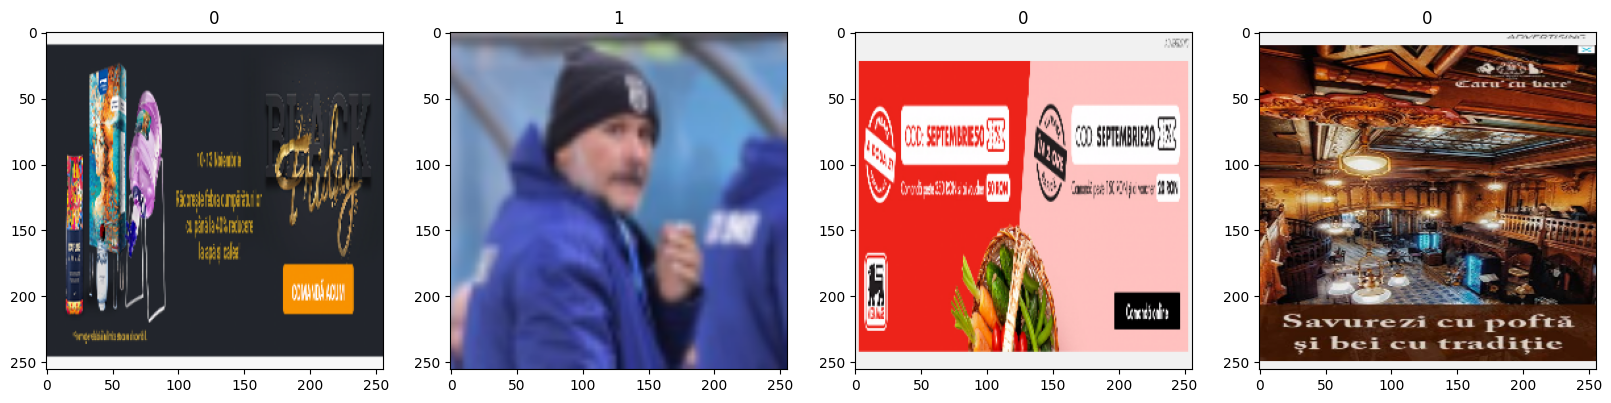

In [215]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

As we can see the labels will be: 
- 1 for Non Ad
- 0 for Ad

#### 2. Preprocessing

##### 2.1 Scale Data

In [216]:
normalized_data = batched_dataset.map(lambda x, y: (x/255, y))

Check if data is normalized between 0 and 1 

In [219]:
normalized_data.as_numpy_iterator().next()[0].max()

1.0

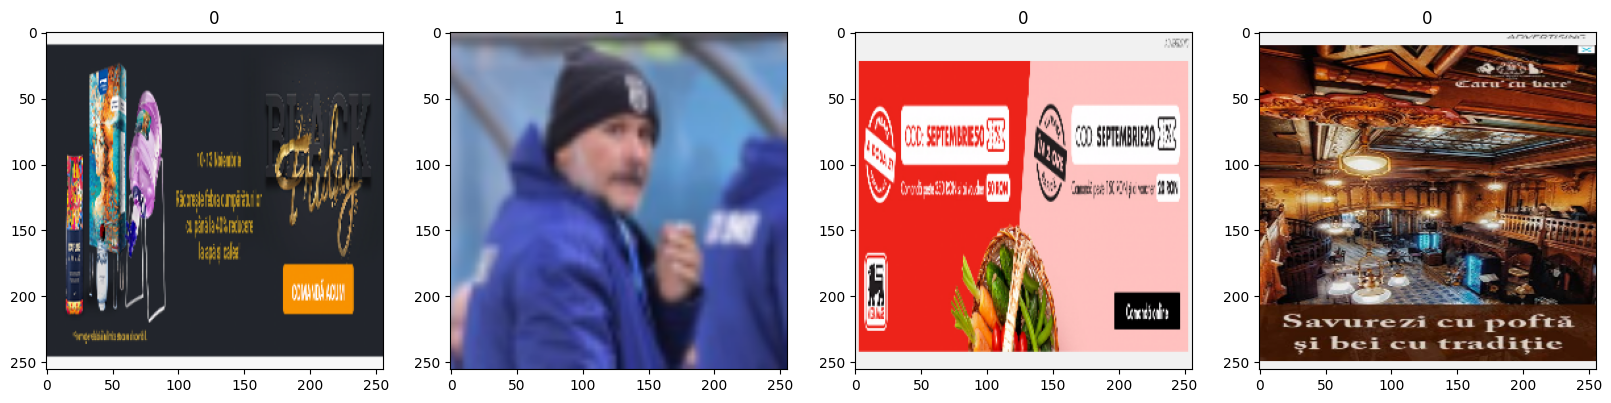

In [220]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

##### 2.2 Split Data 

Checking the length of our data in number of batches

In [222]:
len(normalized_data)

4

In [223]:
train_size = int(len(normalized_data)*.7)
val_size = int(len(normalized_data)*.2)+1
test_size = int(len(normalized_data)*.1)+1

In [224]:
train = normalized_data.take(train_size)
val = normalized_data.skip(train_size).take(val_size)
test = normalized_data.skip(train_size+val_size).take(test_size)

In [225]:
len(test)

1

#### 3. Deep Model

##### 3.1 Build the model

In [226]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [227]:
# Data augmentation layer to randomly rotate, flip, and zoom the images
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

model = keras.Sequential([
    # Apply data augmentation to the input images
    data_augmentation,
    # Convolutional layer with 32 filters and a kernel size of 3
    layers.Conv2D(32, 3, activation='relu', input_shape=(256, 256, 3)),
    # Batch normalization layer to normalize the inputs of the convolutional layer
    layers.BatchNormalization(),
    # Max-pooling layer with a pool size of 2
    layers.MaxPooling2D(),
    # Dropout layer with a rate of 0.2 to randomly drop out 20% of the units
    layers.Dropout(0.2),
    # Convolutional layer with 64 filters and a kernel size of 3
    layers.Conv2D(64, 3, activation='relu'),
    # Batch normalization layer to normalize the inputs of the convolutional layer
    layers.BatchNormalization(),
    # Max-pooling layer with a pool size of 2
    layers.MaxPooling2D(),
    # Dropout layer with a rate of 0.2 to randomly drop out 20% of the units
    layers.Dropout(0.2),
    # Flatten layer to convert the feature maps into a 1D tensor
    layers.Flatten(),
    # Fully connected layer with 128 units and ReLU activation
    layers.Dense(128, activation='relu'),
    # Batch normalization layer to normalize the inputs of the fully connected layer
    layers.BatchNormalization(),
    # Dropout layer with a rate of 0.5 to randomly drop out 50% of the units
    layers.Dropout(0.5),
    # Output layer with a single unit and sigmoid activation for binary classification
    layers.Dense(1, activation='sigmoid')
])

In [228]:
# Build the model
model.build(input_shape=(32, 256, 256, 3))
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [229]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_14 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 batch_normalization_3 (Bat  (32, 254, 254, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_3 (Dropout)         (32, 127, 127, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (32, 125, 125, 64)       

##### 3.2 Train

In [230]:
logdir='logs'

In [231]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [233]:
# Fit the model using the training dataset
hist = model.fit(train, epochs=300, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/300
2/2 [==============================] - 0s 203ms/step - loss: 0.1417 - accuracy: 0.9219 - val_loss: 2.0829 - val_accuracy: 0.5625
Epoch 2/300
2/2 [==============================] - 0s 192ms/step - loss: 0.1305 - accuracy: 0.9688 - val_loss: 2.8947 - val_accuracy: 0.4062
Epoch 3/300
2/2 [==============================] - 0s 196ms/step - loss: 0.1023 - accuracy: 0.9531 - val_loss: 3.6930 - val_accuracy: 0.4062
Epoch 4/300
2/2 [==============================] - 0s 192ms/step - loss: 0.2147 - accuracy: 0.9219 - val_loss: 3.7125 - val_accuracy: 0.5312
Epoch 5/300
2/2 [==============================] - 0s 189ms/step - loss: 0.0917 - accuracy: 0.9375 - val_loss: 3.9419 - val_accuracy: 0.5000
Epoch 6/300
2/2 [==============================] - 0s 191ms/step - loss: 0.1716 - accuracy: 0.9062 - val_loss: 4.1849 - val_accuracy: 0.5312
Epoch 7/300
2/2 [==============================] - 0s 189ms/step - loss: 0.0889 - accuracy: 0.9688 - val_loss: 5.2161 - val_accuracy: 0.4375
Epoch 8/300
2

3.3 Plot Performance

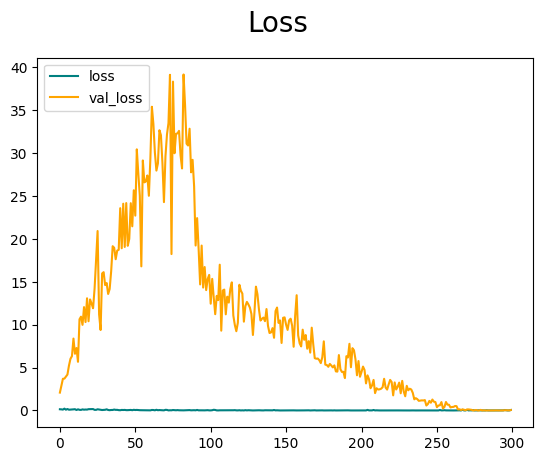

In [234]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

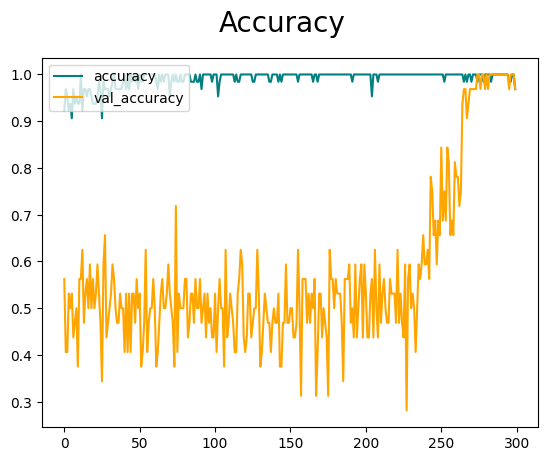

In [235]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#### 4. Evaluate Performance

4.1 Evaluate

In [236]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [237]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [238]:
len(test)

1

In [239]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 159ms/step


In [240]:
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}')

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


4.2 Test

1/1 [==============================] - 0s 13ms/step


IndexError: index 5 is out of bounds for axis 0 with size 5

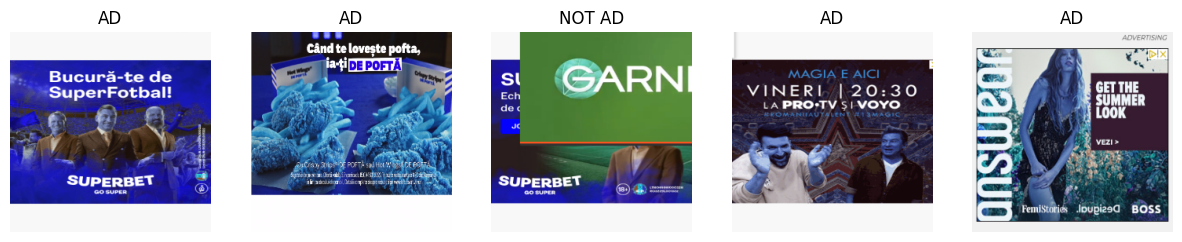

In [312]:
import cv2

base_url = '/data/val/ad/'
resized_images = []

# Get a list of image names in the directory
image_names = os.listdir(base_url)

# Set up the figure and axes for subplots
num_images = len(image_names)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, image_name in enumerate(image_names):
    img_non_ad = cv2.imread(os.path.join(base_url, image_name))
    resized_image = tf.image.resize(img_non_ad, (256, 256))
    resized_images.append(resized_image)
    
    # Convert image to uint8 and display in the current subplot
    ax = axes[i]
    ax.imshow(tf.cast(resized_image, tf.uint8))
    yhat_pred = model.predict(np.expand_dims(resized_image/255, 0))
    title = ''
    if yhat_pred < 0.5: 
        title = 'AD'
    else :
        title = 'NOT AD'
    ax.set_title(title)
    ax.axis('off')  # Turn off axis labels and ticks

# plt.tight_layout()
plt.show()

#### 5. Save the Model

##### 5.1 Save and Load the Model

In [ ]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models', 'adnonadmodel.h5'))
new_model = load_model(os.path.join('models', 'adnonadmodel.h5'))

In [ ]:

yhat_new = new_model.predict(np.expand_dims(resized_nonad/255, 0))

In [ ]:
if yhat_new < 0.5: 
    print(f'With a confidence of {int((abs(yhat_new-1)*100)[0][0])}percent')
    print(f'The image is AD')
else: 
    print(f'With a confidence of {int((yhat_new*100)[0][0])}percent')
    print(f'The image is NOT AD')

In [ ]:
!tensorflowjs_converter --input_format=keras /mnt/c/Users/daniel2.DESKTOP-ARTCORE/Documents/AdVision/adblocker/pyton/jupyter/models/adnonadmodel.h5 /mnt/c/Users/daniel2.DESKTOP-ARTCORE/Documents/AdVision/adblocker/pyton/jupyter/models/tfjs_model